In [29]:
import numpy as np
from scipy.sparse import diags, kron, csr_matrix, csc_matrix, identity, block_diag
from scipy.sparse.linalg import spsolve, norm, inv, eigsh, eigs
import matplotlib.pyplot as plt
from matplotlib import rc
import pandas as pd
import seaborn as sns
rc('text', usetex=True) # para usar latex en matplotlib

In [201]:
def A(un, domain, dim):
    
    a = lambda x: 1
    b = lambda x: 1
    kappa = 1
    
    cache_norm_grad = {}
    def norm_grad(un, p):
        ix = domain.index(p)
        if ix not in cache_norm_grad.keys():
            cache_norm_grad[ix] = 1
        return cache_norm_grad[ix]
    
    cache_harmonic_mean = {}
    def harmonic_mean(un, p, m):
        ix = domain.index(p)
        jx = domain.index(m)
        if (ix, jx) not in cache_harmonic_mean.keys():
            cache_harmonic_mean[(ix, jx)] = 1
        return cache_harmonic_mean[(ix, jx)]
        
    
    def neighbours(p, l="x"):
        px, py = p
        
        if l == "x":
            o = [ (px, py-1), (px, py+1) ]
            
        elif l == "y":
            o = [ (px-1, py), (px+1, py) ]
            
        return [m  for m in o if m in domain]
    
    def get_sigma(p):
        sum_N = sum( harmonic_mean(un, p, m) for m in neighbours(p, l="x") + neighbours(p, l="y") )
        return - a(p) * norm_grad(un, p) * sum_N
    
    def get_delta(p, m):
        return - a(p) * norm_grad(un, p) * harmonic_mean(un, p, m)
    
    def coord_to_ix(p):
        return domain.index(p)
    
    def get_A_row(row):
        px = row
        
        D = [ get_sigma( (px, c) ) for c in range( dim[1] ) ]                 # 0,1,...,c-2,c-1
        D1 = [ get_delta( (px, c), (px, c+1) ) for c in range( dim[1] - 1 ) ] # 0,1,...,c-2
        D_1 = [ get_delta( (px, c), (px, c-1) )  for c in range(1, dim[1] ) ] #   1,...,c-2,c-1
    
        
        k = np.array([D_1, D, D1], dtype= object)
        offset = [-1, 0, 1]
        
        return diags(k, offset)
    
    def get_A_star_row(row, star):
        px = row
        
        D = [ get_delta( (px, c), (px+star, c) ) for c in range( dim[1] ) ]
        
        k = D
        offset = 0
        
        return diags(k, offset)
    
    D = [ get_A_row(row) for row in range( dim[0] ) ]                                                     # 0,1,...,c-2,c-1
    D1 =  [csr_matrix(np.zeros((dim[1], dim[1])))] + [ get_A_star_row(row, star=1) for row in range( dim[0] - 1 ) ] + [csr_matrix(np.zeros((dim[1], dim[1])))] # 0,1,...,c-2
    D_1 = [csr_matrix(np.zeros((dim[1], dim[1])))] + [ get_A_star_row(row, star=-1) for row in range(1, dim[0] ) ] + [csr_matrix(np.zeros((dim[1], dim[1])))]  #   1,...,c-2,c-1

    A0 = block_diag(D)
    A1 = csr_matrix(block_diag(D1).todense()[dim[1]:,:-dim[1]])
    A2 = csr_matrix(block_diag(D1).todense()[:-dim[1],dim[1]:])

    return csr_matrix(A0+A1+A2)
    

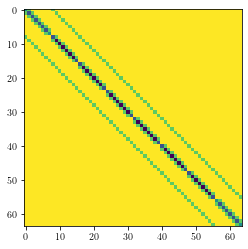

In [217]:
dim = (8, 8)
domain = [ 
    (x, y) for x in range( dim[0] ) for y in range( dim[1] )
]

un = np.zeros(dim[0] * dim[1])
plt.imshow(A(un, domain, dim).todense())